In [64]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import segmentation, color
from skimage.future import graph
from skimage.segmentation import quickshift
import os
import math
from PIL import Image

In [65]:
def sliding_window(image):
    cell_size = (8, 8)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    step_size_x =120; # slide one cell
    step_size_y = 60;
    window_size = (120, 120) # h x w in pixels slide one block
    nbins = 9  # number of orientation bins
    windows = []
    for y in range(0, image.shape[0], step_size_y):
        for x in range(0, image.shape[1], step_size_x):
            window = image[y:y + window_size[1], x:x + window_size[0]]
            window = np.array(window)
            windows.append((x,y,window))
    return windows

In [66]:
# (Suggestion: Make a function which takes list of images as arguments 
# and delivers list of HoG features as output. The same function can
# be used during testing.)
def HoG_features(images):
    
    cell_size = (4, 4)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    nbins = 9  # number of orientation bins

    hog_feats = []
    for image in images:
        # create HoG Object
        # winSize is the size of the image cropped to multiple of the cell size
        # all arguments should be given in terms of number of pixels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Need to denoise the image
        image = cv2.GaussianBlur(image, (5,5), 0)
        hog = cv2.HOGDescriptor(_winSize=(image.shape[1] // cell_size[1] * cell_size[1],
                                          image.shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)
        n_cells = (image.shape[0] // cell_size[0], image.shape[1] // cell_size[1]) #15//7 then it will give me an int

        # 3. Calculate and store the mean feature map across training images.
        # Compute HoG features
        # This hog_feats is just a long vector
        # need to resize
        hog_feat = hog.compute(image) \
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[1], block_size[0], nbins) \
                       .transpose((1, 0, 3, 2, 4))  # index blocks by rows first
        hog_feats.append(hog_feat)
    return hog_feats

In [67]:
# (Suggestion: Make a function which takes list of images as arguments 
# and delivers list of HoG features as output. The same function can
# be used during testing.)
def hog_features_back_dict(images):
    
    cell_size = (4, 4)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    nbins = 9  # number of orientation bins

    hog_feats_dict = {}
    for index in images.keys():
        image = images[index]
        img = image[2]
        # create HoG Object
        # winSize is the size of the image cropped to multiple of the cell size
        # all arguments should be given in terms of number of pixels
        hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                          img.shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)
        n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1]) #15//7 then it will give me an int

        # 3. Calculate and store the mean feature map across training images.
        # Compute HoG features
        # This hog_feats is just a long vector
        # need to resize
        hog_feat = hog.compute(img) \
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[1], block_size[0], nbins) \
                       .transpose((1, 0, 3, 2, 4))  # index blocks by rows first
        
        hog_feats_dict[index] = hog_feat
    return hog_feats_dict

14 Ford training images
1 Ford testing images


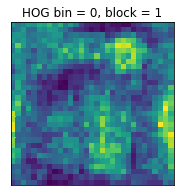

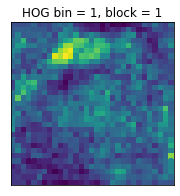

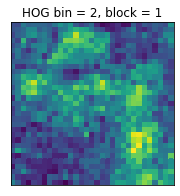

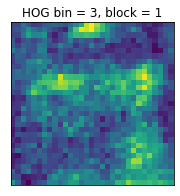

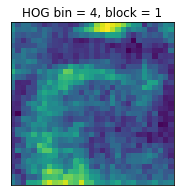

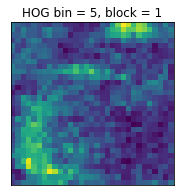

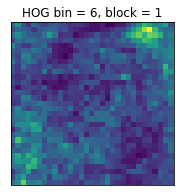

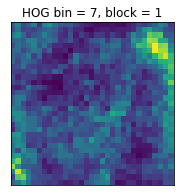

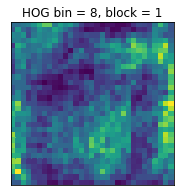

In [107]:
# 1. Resize the training images to 128 x 128.
# Load images and store them in training and test sets 
data = os.listdir('./')
car_train = []
car_test = []
size = (128, 128)

# Resize and store training and test images 
for file in data: 
    if not file.endswith('.jpg'):
        continue
    img = Image.open(file)
    if (len(img.size) == 2): 
        img = img.convert('RGB')  
    img = img.resize(size)
    img = np.array(img)
    
    if file.startswith('car'): 
        car_train.append(img)
    elif file.startswith('test'):
        car_test.append(img)
        
print('{} Ford training images'.format(len(car_train)))
print('{} Ford testing images'.format(len(car_test)))

# 2. Compute HoG features using cell size of 4 x 4 pixels, block size of 2 x 2 cells and 9 orientation bins
train_features = HoG_features(car_train)
mean_feature = sum(train_features)/len(train_features)
# grandient = train_features.get(1)
for i in sorted(range(9)):
    plt.figure(figsize = (3,3))
    plt.pcolor(mean_feature[:, :, 0,0,i])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("HOG bin = {}, block = 1".format(i)), plt.xticks([]), plt.yticks([])


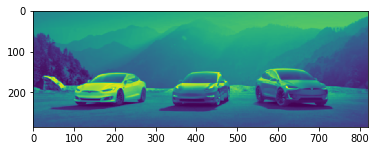

24899.912778991387


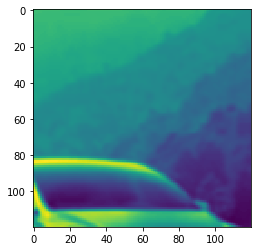

24994.65168779534


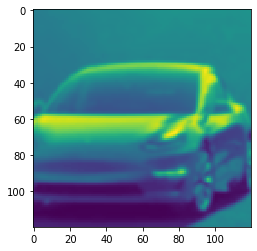

24733.748268023875


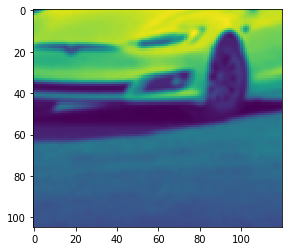

In [104]:
image = cv2.imread("test.jpg")
# First need to grayscale the images
# for image in car_test:
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# Need to denoise the image
image_gray = cv2.GaussianBlur(image_gray, (5,5), 0)
plt.imshow(image_gray)
plt.show()
windows = sliding_window(image_gray)

# windows = sliding_window(image)

# Need to resize the window to 128 x 128
size = (128,128)
windows_dict = {}
i = 0
for window in windows:
    w = np.resize(window[2],size)
    windows_dict[i] = (window[0], window[1], w, window[2])
    i -= -1 # may the world peace

test_features_dict = hog_features_back_dict(windows_dict)

image = cv2.imread("test.jpg")
img_disp = image.copy()
for index in test_features_dict.keys():
    eucl_dist = cv2.norm(mean_feature - test_features_dict[index])*1000
#     if 24.7 < eucl_dist and eucl_dist < 25:
    if 24700 < eucl_dist and eucl_dist < 25000:
        print(eucl_dist)
        window = windows_dict[index]
        x = window[0]
        y = window[1]
#         print(window[3])
        winW = window[3].shape[1]
        winH = window[3].shape[0]
        plt.imshow(window[3])
        plt.show()
        if winW > 100 and winH > 100:
            cv2.rectangle(img_disp, (x, y), 
                          (x + winW, y + winH), (0,255,0), 3)

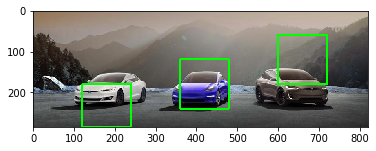

24843.614463406273


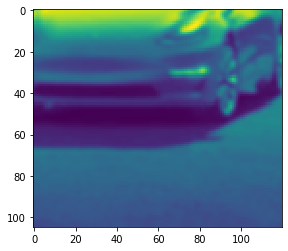

24562.6870309952


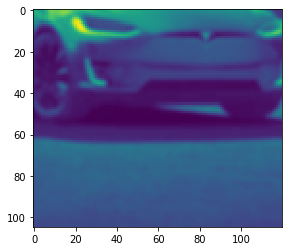

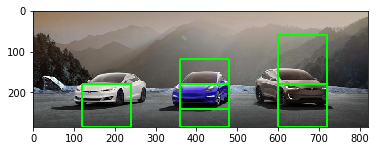

In [105]:
# plt.imshow(image)
# plt.show()
plt.imshow(img_disp)
plt.show()
car_train_flip = []
for image in car_train:
    img = cv2.flip(image,1) #flip horizontal
    car_train_flip.append(img)

train_features_flip = HoG_features(car_train_flip)
mean_feature_flip = sum(train_features_flip)/len(train_features_flip)

for index in test_features_dict.keys():
    eucl_dist = cv2.norm(mean_feature_flip - test_features_dict[index])*1000
    if 24500 < eucl_dist and eucl_dist < 25000:
        print(eucl_dist)
        window = windows_dict[index]
        x = window[0]
        y = window[1]
        winW = window[3].shape[1]
        winH = window[3].shape[0]
        plt.imshow(window[3])
        plt.show()
#         print('winW : {}, winH: {}'.format(winW,winH))
        if winW > 100 and winH > 100:
            cv2.rectangle(img_disp, (x, y), 
                        (x + winW, y + winH), (0,255,0), 3)
#         print('x = {}, y = {}, winW = {}, winH = {}'.format(x,y,winW,winH))
plt.imshow(img_disp)
plt.show()